# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 2.5: Model and Estimate Instability

### 2.5.1 Model and Estimate Instability

Modelling is inherently a tricky affair, with lots of factors playing into the ability for the model to be *useful*. Normally, useful for prediction.

If we consider the following use case:

1. We develop and train a statistical model on a set of data, known as the *training data*
2. We evaluate the model on a set of data not in the training data, which is the *test* or *evaluation* data
3. We use the model for predicting data that was not in either the training or testing set - new data from the real world.

A key assumption behind this process being viable is that the process for generating the data stays the same, across the train, test and real world. If those parameters change, then our model is not useful for prediction, regardless of how well it fits the training data.

A recent event that has caused controversy is when face recognition systems fail to detect people of colour. Joy Buolamwini is a computer scientist and activist working to ensure facial recognition systems work beyond their training data of "predominately white males". You can learn more about her work here: https://www.ajlunited.org/the-coded-gaze

<a href="https://www.youtube.com/watch?v=162VzSzzoPs"><img src="img/facial_recognition.png"></a>

Without such bias (intended or accidental), it would be rare (perhaps unlucky) for the parameters to change as soon as we switch from evaluation to real world use. For example, your trained quant model may be deployed immediately before a new regulation changes market dynamics dramatically.

More likely is that the parameters are constantly changing, with respect to our model. This happens if the model itself underfits the data. That is, the model doesn't adequately understand the process for generating the data.

One way to evaluate whether your model is adequately fitting is to check that the parameters are stable when the data changes. One way of performing this would be to split your training data up, train on each split, and then examine the parameters for each:

In [1]:
%run setup.ipy

In [2]:
x = np.linspace(-20, 20, 100)

In [3]:
y = x ** 2 - 2 * x + 5

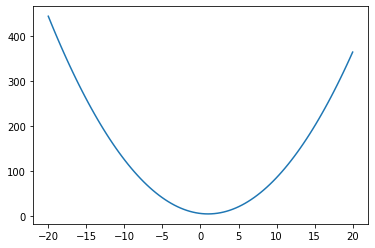

In [4]:
plt.plot(x, y)

Here, if we fit a linear regression model, the result will be flat:

In [5]:
# Using NumPy. You can use statsmodels as well
params = np.polyfit(x, y, 1)
params

array([ -2.        , 141.02693603])

In [6]:
y_pred = np.poly1d(params)(x)

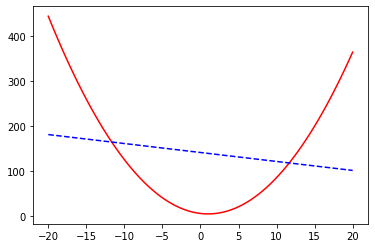

In [7]:
plt.plot(x, y, 'r-')  # Actual data in red
plt.plot(x, y_pred, 'b--')  # Predicted data in blue

While this is a contrived and easy to spot example, this type of underfitting can be much harder to see, but still present, in many real world applications.

If we suspect we aren't fitting the model correctly (for instance, check the residual plot as we saw in the previous modules), we can fit the model to a subset of the data and compare the models:

In [16]:
# Get all the negative values for x
x_low = x[x < 0]
y_low = y[x < 0]
# Get all the positive values for x
x_high = x[x >= 0]
y_high = y[x >= 0]


# Fit model to each
params_low = np.polyfit(x_low, y_low, 1)
params_high = np.polyfit(x_high, y_high, 1)

See how the parameters are drastically different for these two subsets:

In [17]:
params_low

array([-22.2020202 , -63.03387409])

In [18]:
params_high

array([ 18.2020202 , -63.03387409])

(Side note: the same y-intercept is simply because our model is symmetrical about the y-axis. If you are unsure about this, see the next figure.)

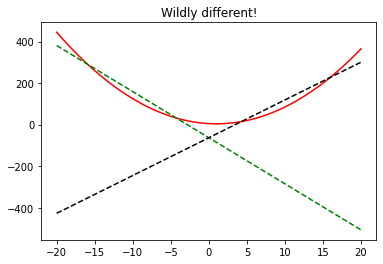

In [19]:
plt.plot(x, y, 'r-')  # Actual data in red

y_pred_low = np.poly1d(params_low)(x)
plt.plot(x, y_pred_low, 'g--')  # Predictions from "low" model in green

y_pred_high = np.poly1d(params_high)(x)
plt.plot(x, y_pred_high, 'k--')  # Predictions from "high" model in black

plt.title("Wildly different!");

Each of these models is a reasonable linear estimator of the area it was asked to fit, however both fail drastically when dealing with the out-of-sample data. If you were to evaluate one line by using the data from the other line, you will get errors that are wildly different from the training data.

There are a few methods to help us here. In our example above, we did a split at $x=0$, but it may not always be obvious if or where such a threshold would sit.

### Cross Fold Validation

A key algorithm for evaluation in statistics, machine learning and artificial intelligence is cross-fold validation (often just "CV"). We looked at this process quickly in an exercise in Module 2.3.1.

This technique splits the dataset into separate subsets, called "folds". Each fold is normally the same size. Where we have $k$ different folds, we refer to the process as $k$-fold cross validation. Normal $k$ values are 3 or 10, but these are just rules of thumb.

Given $k$ folds, we do the following loop $k$ times, and each time we use one fold for testing/evaluation, and the rest of the folds for training the data.

After repeating that loop, we average the evaluation result (i.e. SSE or accuracy) to present the final version. It would also be possible to report confidence bounds on the process and variance. If your evaluation results have a high amount of variance, it is possible your model is insufficiently modelling the data. It could be underfitting and not capturing enough information. It could be overfitting, and capturing too much information. Other methods of analysis can help with fixing the problem once identified.

One type of $k$-fold cross validation is setting $k=n$, where $n$ is the number of samples in your dataset. This is known as "hold one out cross validation". In this version, all-but-one data is used for training, and one sample is used for testing. This is very time consuming and normally not better than smaller numbers of folds. In some cases it can be worse, as there is a large variation in the evaluation results.

Folds in CV are normally randomly split up from the original data. This is effective, and recommended, for non-time series data, but is not a good idea for time series analysis, especially if you suspect lagged correlation at all. Any time where the position of the data in the dataset may affect its value is problematic.

A technique for cross fold validation in time series is the "evaluation on a rolling forecasting origin". In this, we iterate $n$ times ($n$ is the number of data points), and at each iteration $i$ we choose the first $i$ points as the training data, and evaluate on the $(i+m)$th point, where $m$ is usually just 1 - so "the next point". We then evaluate the model over all these iterations. You may be more interested in the prediction one week after the end of the training set and, as an example, set $m=7$ for daily data.


#### Exercise

1. Compute the training and testing SSE for the parabola example above. Use the lower range as your training data, and the upper range as the testing data. Note the wildly different SSE values between the two sets.
2. Test again using a polyfit with degree 2. How does the SSE different change?

In [20]:
#1.
sse_low = np.sum((y_pred_low[0:50] - y_low)**2)
sse_high = np.sum((y_pred_low[50:100] - y_high)**2)
print(sse_low,sse_high)


46175.06583230549 11149281.77142855


In [21]:
#2.
params_low = np.polyfit(x_low, y_low, 2)
params_high = np.polyfit(x_high, y_high, 2)
y_pred_low = np.poly1d(params_low)(x)
y_pred_high = np.poly1d(params_high)(x)
sse_low = np.sum((y_pred_low[0:50] - y_low)**2)
sse_high = np.sum((y_pred_low[50:100] - y_high)**2)
print(sse_low,sse_high)

7.788265945066005e-26 7.756530070848964e-25


*For solutions, see `solutions/polyfit.py`*

#### Extended Exercise

Write a function implementing $m$-step, evaluation on a rolling forecasting origin, cross validation for time series analysis. The input would be your data frame (with a time series index) and the output would be a list of all the folds for the technique. Your function should have the following signature:

```python

def rolling_forecasting_origin(time_series, m=1):
    """Performs a rolling forecasting origin with steps of m
    
    parameters:
        time_series: pandas data frame with a time series index
        m: positive non-zero integer. 1 by default 
       
    returns:
        folds: a list of each of the training and testing folds for pandas.
    """
```

If you are very confident with python, have this function be a generator that `yields` the different training and testing sets.

If you need an alternate description of the technique, see the diagrams and information at https://robjhyndman.com/hyndsight/tscv/ who implemented this technique in R.

As with all large exercises, focus on solving the problem in three distinct steps:

1. Get it working. Just get the function call scoped out and the technique doing what it should. Your code becomes useful in this step.
2. Get it right. Consider edge cases (like a time series with no data points) and how they are handled. Your code becomes robust in this step, usually with the addition of testing code.
3. Make it fast. Only after completing the above steps do you optimise your code to try make it fast.

Note for this exercise, that the process may take a long time to run, especially for large datasets.

In [25]:
def rolling_forecasting_origin(time_series, m=1):
    """Performs a rolling forecasting origin with steps of m

    parameters:
        time_series: pandas data frame with a time series index
        m: positive non-zero integer. 1 by default 

    returns:
        folds: a list of each of the training and testing folds for pandas.
    """
    n = len(time_series)
    split_p = np.arange(m,n-m+1 )
    res = []
    
    for sp in split_p:
        trainrg = np.arange(0,sp+1)
        testrg = np.arange(sp+1,min(sp+m+1,n))
        res.append([trainrg,testrg])
    return res

    

*For solutions, see `solutions/rolling_forecast.py`*

### Checking variance of parameters

Once you have your results of fitting many models with cross-fold validation, you can analyse the fitted parameters. First, check for variance. Second, use those parameters to find your finished model.

In checking for variance, simply check the spread of the values. High values, particularly if some are negative and some are positive, may be indicative of instability in the model. For this to work, though, you must have independent variables in your dataset. If two variables are highly correlated, you may get cases where the shared weight between the two is consistent, but "flipping" from one variable to the other as they both fill the same role in the estimator. 

If the variance is fine, you can then use the parameters to fit your final model - the one that will be used in practice. There are two approaches to doing this:

1. If you are happy with the results, simply fit *the same type* of model on your own dataset, ignoring the features learned during training. Effectively, your training told you "this model type can learn this data in a stable way", so you just train the model using as much of the data as you can.
2. If you are using the OLS or another Linear model (for instance Logistic Regression or Ridge Regression), the final parameters could just be the average of the parameters from each of the fitted models. This is mathematically sound for some model types, and is what the `scikit-learn` package does, for instance in [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)


### Sample Instability

Another approach for checking the stability of the model is to bootstrap sample the training data, fit your model, and compare the variance of parameters over many of these samples. The approach should look familiar to you after previous modules:

1. Sample your data to create a sample-with-replacement with the same size as your original training data
2. Fit your model and note the parameters
3. Repeat steps 1 and 2 many times (if you have the time, do thousands)
4. Compute the mean, variance and confidence intervals of the parameters from the many samples

If your variance is too high, the model is not stable with respect to your data.

If you do get instability here, the likely cause is that your model is underfitting or overfitting the data. This causes the model to adhere to specific characteristics of the model, rather than finding underlying trends in the data. If you are using a simple model, like a basic linear regression, try a more complicated version. If you are using a complicated model, like a neural network, try restricting it or using a simpler model and compare the results.

### Control Charts

Another approach to look for changes in variability in a model (which leads to unstable estimations) is the control chart. A control chart is a simple plot of the data of a single variable over time, but with three extra lines - the mean of the data, the upper control limit (UCL) and the lower control limit (LCL). Normally, the UCL and LCL are three standard deviations from the mean.

This idea of a control chart comes from the six sigma process control methodology.

<div class="alert alert-danger">
    Note that setting the UCL and LCL to three standard deviations is not statistically sound. Normal distributions refer to means of samples, not to individual sample measurements themselves.
</div>

Let's see a control chart for the AUD/USD exchange rate:

In [26]:
import quandl

audusd = quandl.get("RBA/FXRUSD")

In [27]:
changes = audusd.pct_change()

In [28]:
changes.describe()

,Value
count,9481.000000
mean,0.000003
std,0.007190
min,-0.074449
25%,-0.003668
50%,0.000149
75%,0.003920
max,0.074184


In [29]:
ucl = changes.mean() + 3 * changes.std()
lcl = changes.mean() - 3 * changes.std()

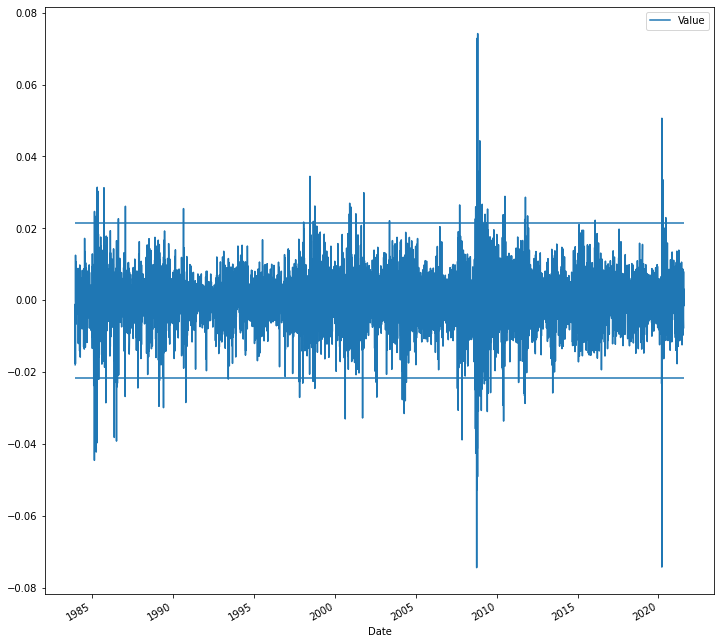

In [30]:
fig, ax, = plt.subplots(figsize=(12, 12))
changes.plot(ax=ax)
ax.hlines([ucl, lcl], xmin=changes.index.min(), xmax=changes.index.max())

Here we can see large changes in quite a few times of financial instability, particularly (and perhaps unsurprisingly) around 2008. However note that the limits are defined by the data - there would *always* be values outside these limits (for a reasonably large dataset), because the limits are defined by the standard deviation, and there should be 99.7% of points inside three standard deviations (if the data was normally distributed, which we haven't tested here).

That said, control limits like these are good for automation. Some common rules of thumb for limits are to alert that a "change from normal" may be present if any of these are true:

* A single point is outside the control limit lines
* 2 out of 3 consecutive points are outside the control limit lines (a bit more robust to noise)
* 10 points in a row are above (or below) the mean line
* 5 points in a row are outside two standard deviations.

It may be possible to setup automated alerts along these lines. For instance, if you have an automated trading bot, and a control limit is breached, this is indicative that the data is not following the model that you trained on. It may be a good idea to halt trading and investigate what is happening.

In addition to charting the raw values (or percentage changes in this case) you could also chart residuals from your linear model, i.e. the difference between the predicted and actual values.

#### Exercise

If you have a subscription to the SGE data set in Quandl, create a control chart on Australian house prices using this dataset: https://www.quandl.com/data/SGE/AUSHOUS-Australia-House-Price-Index

If you do not, choose another commodity from Quandl. You can search Free dataset as an option in the Quandl search: https://www.quandl.com/search - the option for "Free" is on the left hand set of filters.

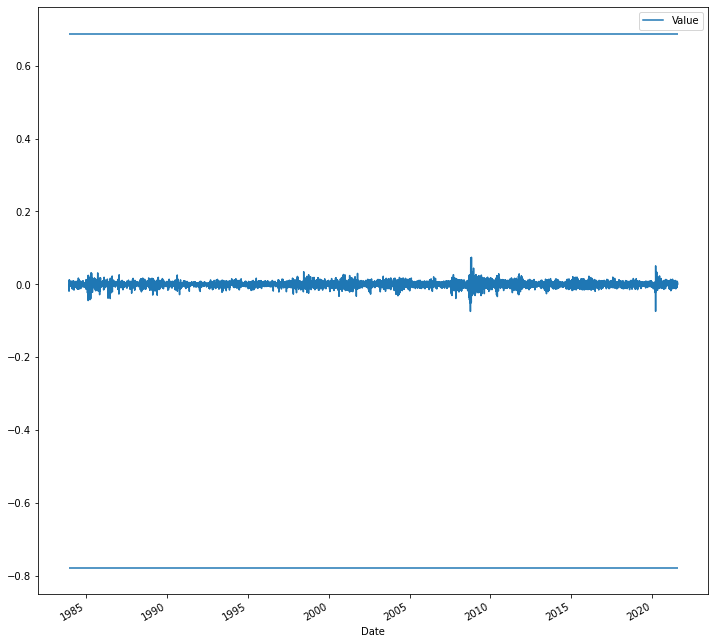

In [37]:
data = quandl.get("RBA/F13_FOOIRATCR")
datadiff = data.diff()
data_ucl = datadiff.mean()+3*datadiff.std()
data_lcl = datadiff.mean()-3*datadiff.std()

fig, ax, = plt.subplots(figsize=(12, 12))
changes.plot(ax=ax)
ax.hlines([data_ucl, data_lcl], xmin=changes.index.min(), xmax=changes.index.max())

*For solutions, see `solutions/control_chart.py`*